# Finetune ResNet50


## resnet50_1080repetitive


With 1920x1080 repetitive-padded melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'resnet50_1080repetitive'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_20972\425797518.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s, Loss=0.7039542198181152, Elapsed=38.9576s, ETA=0.0000s]  


Epoch 1 completed in 173.8621s
Train Loss: 0.9384797098319655 - Train Accuracy: 60.32654168833812
Validation Loss: 0.8679311060905457 - Validation Accuracy: 65.59729843815956

Epoch 2/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.62it/s, Loss=0.11292656511068344, Elapsed=31.5799s, ETA=0.0000s] 


Epoch 2 completed in 136.0438s
Train Loss: 0.6959252439310096 - Train Accuracy: 70.51627055019108
Validation Loss: 0.7070519048968951 - Validation Accuracy: 72.42507387083158

Epoch 3/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.61it/s, Loss=0.26858624815940857, Elapsed=31.7217s, ETA=0.0000s] 


Epoch 3 completed in 136.3906s
Train Loss: 0.5809595154199986 - Train Accuracy: 75.8689310508582
Validation Loss: 0.652089482943217 - Validation Accuracy: 74.54622203461376

Epoch 4/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.59it/s, Loss=0.1164507195353508, Elapsed=31.7876s, ETA=0.0000s]  


Epoch 4 completed in 136.2203s
Train Loss: 0.4766180313736028 - Train Accuracy: 79.77431537052531
Validation Loss: 0.7964657854040463 - Validation Accuracy: 73.64921907978051

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.58it/s, Loss=0.027250735089182854, Elapsed=31.8793s, ETA=0.0000s]


Epoch 5 completed in 136.3522s
Train Loss: 0.37875439123266696 - Train Accuracy: 83.50105153660026
Validation Loss: 0.7368792231629292 - Validation Accuracy: 73.84972562262558

EarlyStopping counter: 2/5
Epoch 6/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.57it/s, Loss=0.005569249391555786, Elapsed=32.0902s, ETA=0.0000s]


Epoch 6 completed in 136.9427s
Train Loss: 0.30744675228189183 - Train Accuracy: 86.1219782456299
Validation Loss: 0.7687571978569031 - Validation Accuracy: 75.68594343604896

EarlyStopping counter: 3/5
Epoch 7/50


Validating: 100%|██████████| 75/75 [00:21<00:00,  3.57it/s, Loss=0.0008604982285760343, Elapsed=31.9774s, ETA=0.0000s]


Epoch 7 completed in 137.2036s
Train Loss: 0.2341705891653637 - Train Accuracy: 88.96451911987518
Validation Loss: 0.9281365921216396 - Validation Accuracy: 76.45631067961165

EarlyStopping counter: 4/5
Epoch 8/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.57it/s, Loss=0.0007840121979825199, Elapsed=32.1812s, ETA=0.0000s]

Epoch 8 completed in 137.3906s
Train Loss: 0.17912837837128281 - Train Accuracy: 91.26659279527826
Validation Loss: 0.9956846503750421 - Validation Accuracy: 75.03165892781765

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


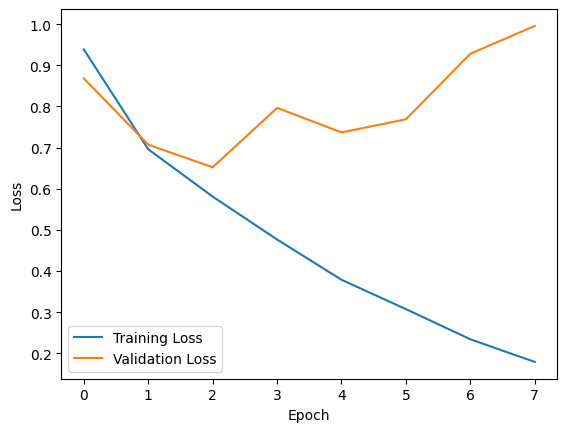

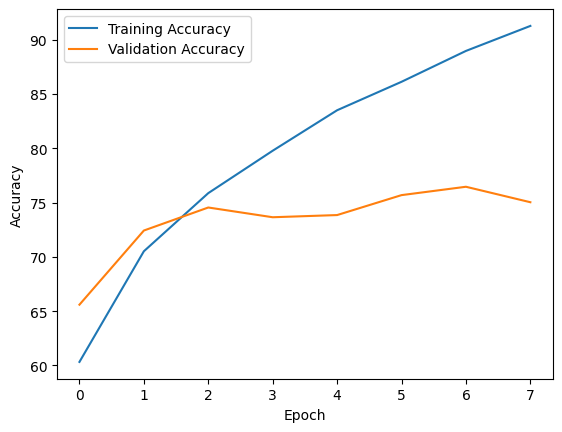

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]

Test Accuracy: 0.7630
Test Precision: 0.7684
Test Recall: 0.7630
Test F1-score: 0.7611

              precision    recall  f1-score   support

       Anger       0.73      0.79      0.76       916
       Bored       0.78      0.94      0.85      1098
     Disgust       0.46      0.51      0.48       291
        Fear       0.65      0.52      0.58       308
       Happy       0.87      0.68      0.76      1914
     Neutral       0.75      0.69      0.72      2226
    Question       0.88      0.93      0.90      1139
         Sad       0.67      0.80      0.73       857
    Surprise       0.72      0.80      0.76       728

    accuracy                           0.76      9477
   macro avg       0.72      0.74      0.73      9477
weighted avg       0.77      0.76      0.76      9477



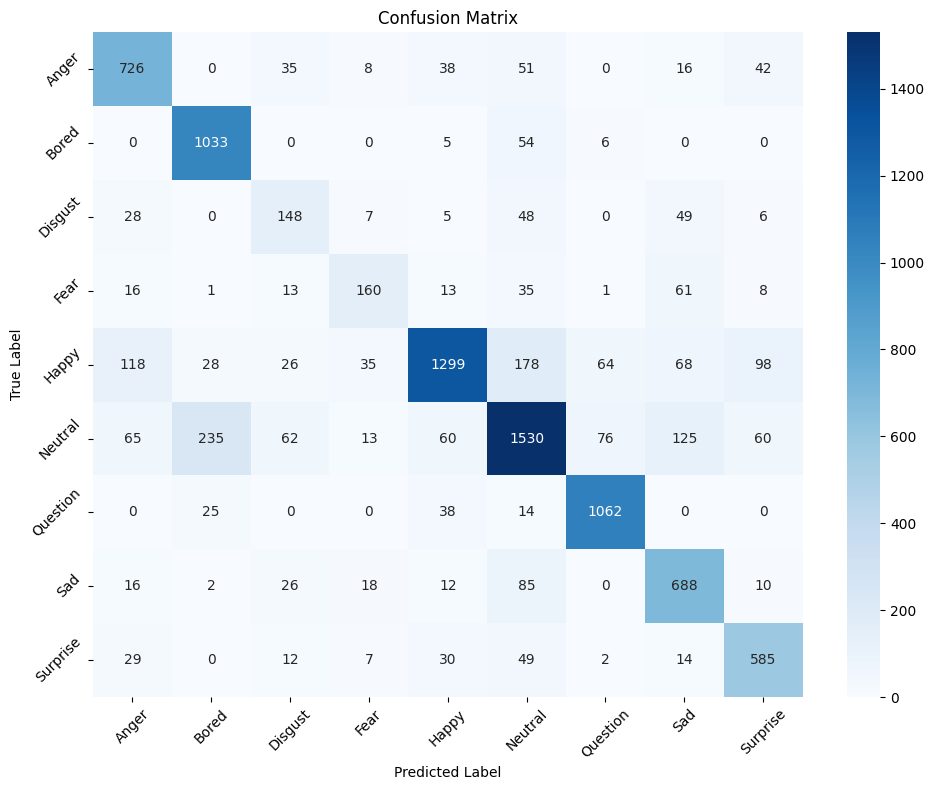

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)